In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import datetime
import os
import sklearn

%load_ext autoreload
%autoreload 1
%aimport ShortTermFeatures

%matplotlib inline
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://github.com/tyiannak/pyAudioAnalysis

## initial attempt

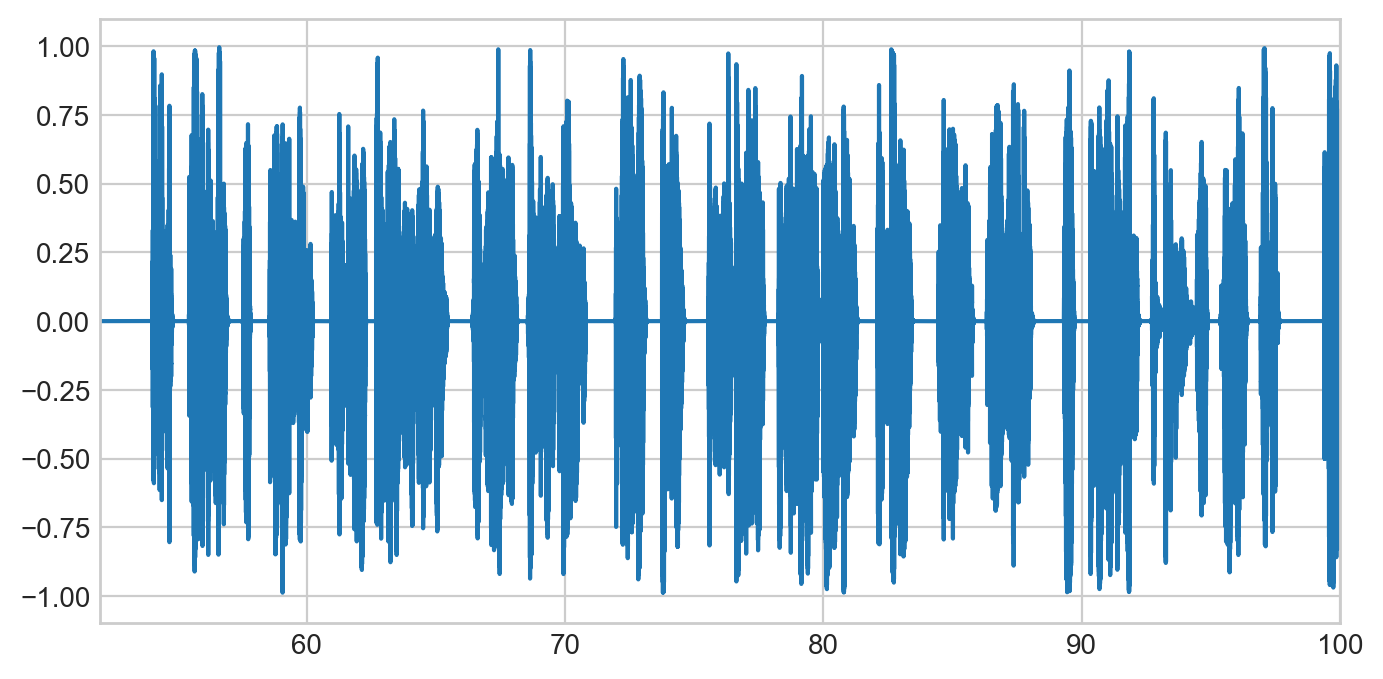

In [83]:
# load audio
filename = './data/Track 2.wav'
data, fs = sf.read(filename, dtype='float32')
time = np.linspace(0, len(data) / fs, num=len(data))

# creat channel name
prefix = 'channel_'
n_channels = data.shape[1]
n_str = np.arange(1, n_channels + 1, 1, dtype=str)
channels = [prefix + i for i in n_str]

# convert to pandas df
pd_data = pd.DataFrame(data, columns=channels)
pd_data['seconds'] = time

# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])

ax.set_xlim([52, 100])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

In [29]:
fs

44100

## investigate opensource

In [140]:
from ShortTermFeatures import feature_extraction

def features_to_matrix(features):
    """
    features_to_matrix(features)

    This function takes a list of feature matrices as argument and returns
    a single concatenated feature matrix and the respective class labels.

    ARGUMENTS:
        - features:        a list of feature matrices

    RETURNS:
        - feature_matrix:    a concatenated matrix of features
        - labels:            a vector of class indices
    """

    labels = np.array([])
    feature_matrix = np.array([])
    for i, f in enumerate(features):
        if i == 0:
            feature_matrix = f
            labels = i * np.ones((len(f), 1))
        else:
            feature_matrix = np.vstack((feature_matrix, f))
            labels = np.append(labels, i * np.ones((len(f), 1)))
    return feature_matrix, labels

#-------------------------------------------------------------------------
def normalize_features(features):
    """
    This function normalizes a feature set to 0-mean and 1-std.
    Used in most classifier trainning cases.

    ARGUMENTS:
        - features:    list of feature matrices (each one of them is a np
                       matrix)
    RETURNS:
        - features_norm:    list of NORMALIZED feature matrices
        - mean:        mean vector
        - std:        std vector
    """
    temp_feats = np.array([])

    for count, f in enumerate(features):
        if f.shape[0] > 0:
            if count == 0:
                temp_feats = f
            else:
                temp_feats = np.vstack((temp_feats, f))
            count += 1

    mean = np.mean(temp_feats, axis=0) + 1e-14
    std = np.std(temp_feats, axis=0) + 1e-14

    features_norm = []
    for f in features:
        ft = f.copy()
        for n_samples in range(f.shape[0]):
            ft[n_samples, :] = (ft[n_samples, :] - mean) / std
        features_norm.append(ft)
    return features_norm, mean, std


#-------------------------------------------------------------------------
def train_svm(features, c_param, kernel='linear'):
    """
    Train a multi-class probabilitistic SVM classifier.
    Note:     This function is simply a wrapper to the sklearn functionality 
              for SVM training
              See function trainSVM_feature() to use a wrapper on both the 
              feature extraction and the SVM training
              (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements 
                            containt np matrices of features  each matrix 
                            features[i] of class i is 
                            [n_samples x numOfDimensions]
        - c_param:           SVM parameter C (cost of constraints violation)
    RETURNS:
        - svm:              the trained SVM variable

    NOTE:
        This function trains a linear-kernel SVM for a given C value.
        For a different kernel, other types of parameters should be provided.
    """

    feature_matrix, labels = features_to_matrix(features)
    svm = sklearn.svm.SVC(C=c_param,
                          kernel=kernel,
                          probability=True,
                          gamma='auto')
    svm.fit(feature_matrix, labels)

    return svm


#-------------------------------------------------------------------------
def smooth_moving_avg(signal, window=11):
    window = int(window)
    if signal.ndim != 1:
        raise ValueError("")
    if signal.size < window:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window < 3:
        return signal
    s = np.r_[2 * signal[0] - signal[window - 1::-1], signal,
              2 * signal[-1] - signal[-1:-window:-1]]
    w = np.ones(window, 'd')
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window:-window + 1]


#-------------------------------------------------------------------------
def silence_removal(signal,
                    sampling_rate,
                    st_win,
                    st_step,
                    smooth_window=0.5,
                    weight=0.5,
                    plot=False):
    """
    Event Detection (silence removal)
    ARGUMENTS:
         - signal:                the input audio signal
         - sampling_rate:               sampling freq
         - st_win, st_step:    window size and step in seconds
         - smoothWindow:     (optinal) smooth window (in seconds)
         - weight:           (optinal) weight factor (0 < weight < 1)
                              the higher, the more strict
         - plot:             (optinal) True if results are to be plotted
    RETURNS:
         - seg_limits:    list of segment limits in seconds (e.g [[0.1, 0.9],
                          [1.4, 3.0]] means that
                          the resulting segments are (0.1 - 0.9) seconds
                          and (1.4, 3.0) seconds
    """

    if weight >= 1:
        weight = 0.99
    if weight <= 0:
        weight = 0.01

    # Step 1: feature extraction

    st_feats, _ = feature_extraction(signal, sampling_rate,
                                     st_win * sampling_rate,
                                     st_step * sampling_rate)

    # Step 2: train binary svm classifier of low vs high energy frames
    # keep only the energy short-term sequence (2nd feature)
    st_energy = st_feats[1, :]
    en = np.sort(st_energy)
    # number of 10% of the total short-term windows
    st_windows_fraction = int(len(en) / 10)

    # compute "lower" 10% energy threshold
    low_threshold = np.mean(en[0:st_windows_fraction]) + 1e-15

    # compute "higher" 10% energy threshold
    high_threshold = np.mean(en[-st_windows_fraction:-1]) + 1e-15

    # get all features that correspond to low energy
    low_energy = st_feats[:, np.where(st_energy <= low_threshold)[0]]

    # get all features that correspond to high energy
    high_energy = st_feats[:, np.where(st_energy >= high_threshold)[0]]

    # form the binary classification task and ...
    features = [low_energy.T, high_energy.T]
    # normalize and train the respective svm probabilistic model

    # (ONSET vs SILENCE)
    features_norm, mean, std = normalize_features(features)
    svm = train_svm(features_norm, 1.0)

    # Step 3: compute onset probability based on the trained svm
    prob_on_set = []
    for index in range(st_feats.shape[1]):
        # for each frame
        cur_fv = (st_feats[:, index] - mean) / std
        # get svm probability (that it belongs to the ONSET class)
        prob_on_set.append(svm.predict_proba(cur_fv.reshape(1, -1))[0][1])
    prob_on_set = np.array(prob_on_set)

    # smooth probability:
    prob_on_set = smooth_moving_avg(prob_on_set, smooth_window / st_step)

    # Step 4A: detect onset frame indices:
    prog_on_set_sort = np.sort(prob_on_set)

    # find probability Threshold as a weighted average
    # of top 10% and lower 10% of the values
    nt = int(prog_on_set_sort.shape[0] / 10)
    threshold = (np.mean((1 - weight) * prog_on_set_sort[0:nt]) +
                 weight * np.mean(prog_on_set_sort[-nt::]))

    max_indices = np.where(prob_on_set > threshold)[0]
    # get the indices of the frames that satisfy the thresholding
    index = 0
    seg_limits = []
    time_clusters = []

    # Step 4B: group frame indices to onset segments
    while index < len(max_indices):
        # for each of the detected onset indices
        cur_cluster = [max_indices[index]]
        if index == len(max_indices) - 1:
            break
        while max_indices[index + 1] - cur_cluster[-1] <= 2:
            cur_cluster.append(max_indices[index + 1])
            index += 1
            if index == len(max_indices) - 1:
                break
        index += 1
        time_clusters.append(cur_cluster)
        seg_limits.append(
            [cur_cluster[0] * st_step, cur_cluster[-1] * st_step])

    # Step 5: Post process: remove very small segments:
    min_duration = 0.2
    seg_limits_2 = []
    for s_lim in seg_limits:
        if s_lim[1] - s_lim[0] > min_duration:
            seg_limits_2.append(s_lim)
    seg_limits = seg_limits_2

    if plot:
        time_x = np.arange(0, signal.shape[0] / float(sampling_rate),
                           1.0 / sampling_rate)

        fig, ax = plt.subplots(1, 1, figsize=(8,4))
        ax.plot(time_x, signal)
        for s_lim in seg_limits:
            ax.axvline(x=s_lim[0], color='red', lw=0.5)
            ax.axvline(x=s_lim[1], color='red', lw=0.5)
        
        ax.set_xlim([0, 50])
        plt.show()

    return seg_limits

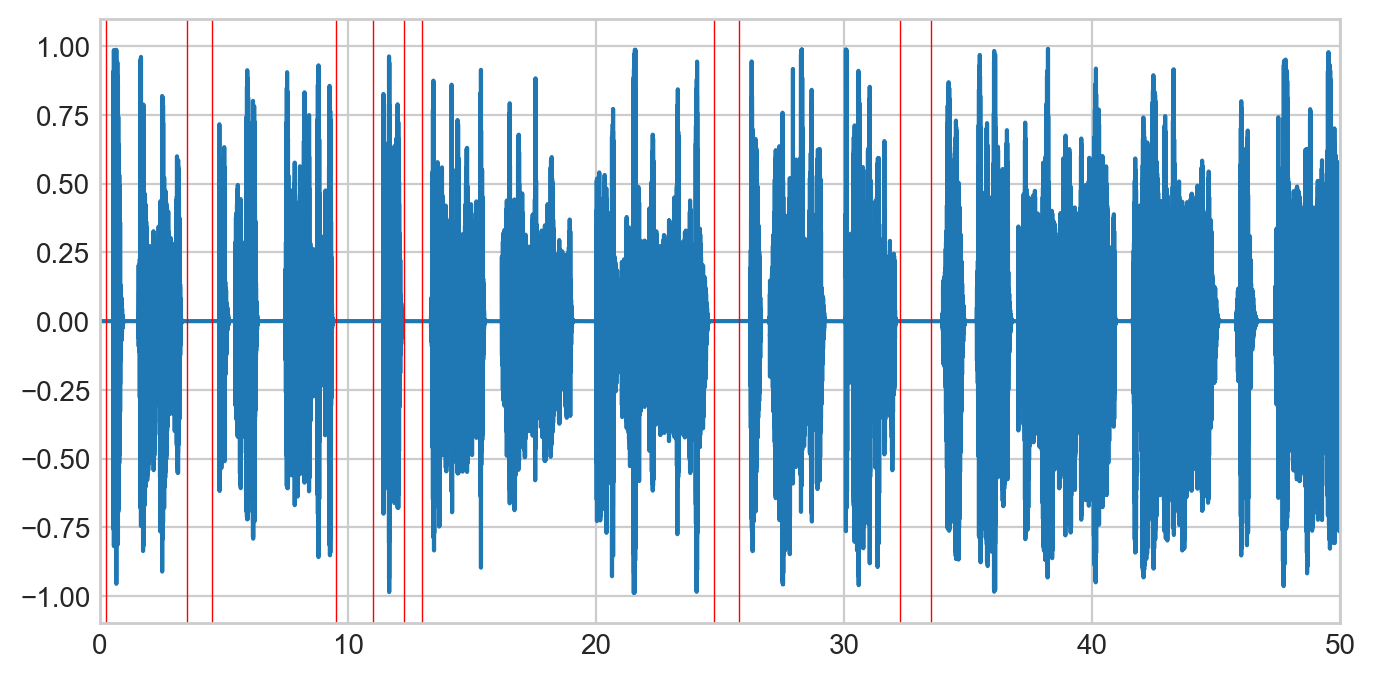

11


[[0.25, 3.5],
 [4.5, 9.5],
 [11.0, 12.25],
 [13.0, 24.75],
 [25.75, 32.25],
 [33.5, 52.0],
 [53.75, 88.25],
 [89.0, 97.75],
 [99.0, 123.75],
 [124.75, 128.0],
 [128.75, 152.0]]

In [143]:
segments = silence_removal(data[:,0], fs, 0.5, 0.25, 1, 0.1, True)
print(len(segments))
segments

In [124]:
# str(datetime.timedelta(seconds=65066))
# apt-get install ffmpeg libavcodec-extra

'18:04:26'